# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
#import sys
#!{sys.executable} -m pip install -I networkx==2.1
#import pkg_resources
#pkg_resources.require("networkx==2.1")
import networkx as nx

In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from sklearn.neighbors import KDTree
from queue import PriorityQueue

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [54]:
def extract_polygons(data):

    polygons = []
    points = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        corners = [(north - d_north, east - d_east), (north + d_north, east - d_east), (north + d_north, east + d_east), (north - d_north, east + d_east)]
        height = alt + d_alt
        p = Polygon(corners)
        polygons.append((p, height))
        points.append(np.array([north, east, alt]))
    tree = KDTree(points)
    return polygons, tree

def collides(polygons, tree, point):
    idx = tree.query(np.array([point[0], point[1], point[2]]).reshape(1,-1), k=3, return_distance=False)[0]
    for i in idx:
        polygon, height = polygons[i]
        if point[2] < height:
            if polygon.contains(Point(point[0], point[1])):
                return True
    return False

polygons, tree_polygon = extract_polygons(data)

xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

zmin = 0
zmax = 10

num_samples = 1000

xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)

samples = list(zip(xvals, yvals, zvals))

to_keep = []
for point in samples:
    if not collides(polygons, tree_polygon, point):
        to_keep.append(point)

print (tree_polygon.data)
print (data[0,:])

# then use KDTree to find nearest neighbor polygon
# and test for collision

<MemoryView of 'array' object>
[-310.2389 -439.2315   85.5       5.        5.       85.5   ]


## Step 3 - Connect Nodes


Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [59]:
def intersect (line_object, polygon_object):
    return line_object.crosses(polygon_object)

def can_connect(pt_1, pt_2, polygon_object):
    if polygon_object[1] < pt_1[2] and polygon_object[1] < pt_2[2]:
        return True;
    else:
        line_object = LineString(((pt_1[0], pt_1[1]), (pt_2[0], pt_2[1])))
        return not intersect(line_object, polygon_object[0])

def create_graph(node_points, tree_polygon, polygons):
    graph = nx.Graph()
    graph.add_nodes_from(range(0,len(node_points)))
    node_tree = KDTree(node_points)
    for node_point_id in range(0, len(node_points)):
        node_point = node_points[node_point_id]
        candidate_ids = node_tree.query(np.array([node_point[0], node_point[1], node_point[2]]).reshape(1,-1), k=5, return_distance=False)[0]
        for candidate_id in candidate_ids:
            # if edge noe cross then add add to graph
            candidate_point = node_points[candidate_id]
            polygon_ids_1 = tree_polygon.query(np.array([node_point[0], node_point[1], node_point[2]]).reshape(1,-1), k=3, return_distance=False)[0]
            polygon_ids_2 = tree_polygon.query(np.array([candidate_point[0], candidate_point[1], candidate_point[2]]).reshape(1,-1), k=3, return_distance=False)[0]
            polygon_ids = polygon_ids_1
            for i in polygon_ids_2:
                if i not in polygon_ids_1:
                    np.insert(polygon_ids, -1, i)
            for polygon_id in polygon_ids:
                if can_connect(node_point, candidate_point, polygons[polygon_id]):
                    graph.add_edge(node_point_id, candidate_id)
                    break        
    return graph

graph = create_graph(to_keep, tree_polygon, polygons)
        

# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!

## Step 4 - Visualize Graph

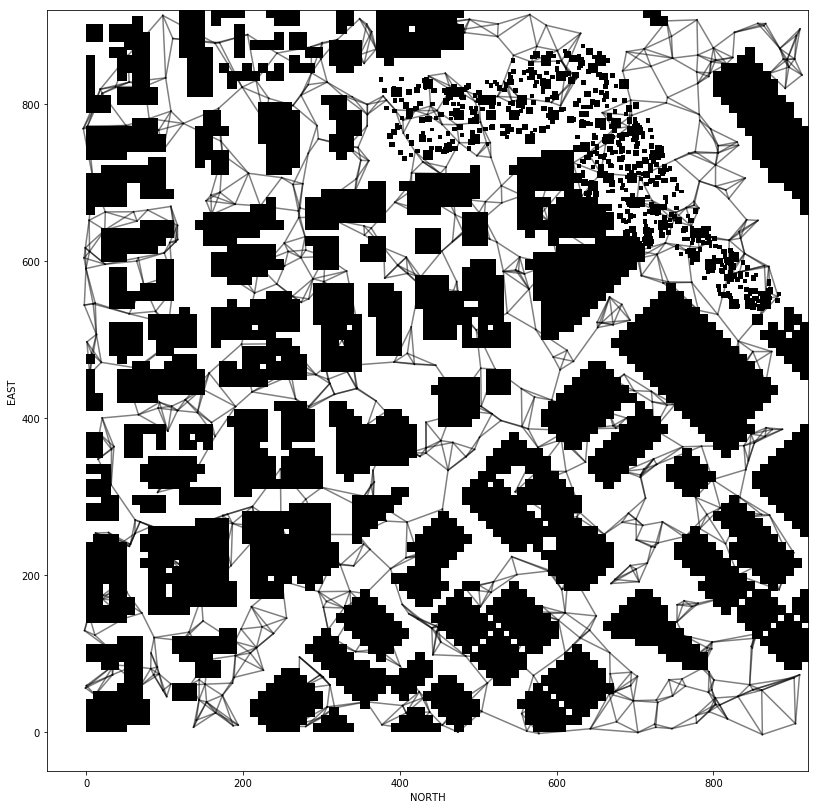

In [60]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in graph.edges:
    n1 = to_keep[n1]
    n2 = to_keep[n2]
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
#for n1 in nodes:
#    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
#for n1 in g.nodes:
#    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [ ]:
def heuristic(n1, n2):
    # TODO: complete
    return 0

## Step 6 - Complete A*

In [ ]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete
    return []



## Step 7 - Visualize Path

In [ ]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

# Add code to visualize path here

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)